# Credit Scoring

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# EDA

In [4]:
df = pd.read_csv("Creditscoring.csv")

In [5]:
df.columns = df.columns.str.lower()

In [7]:
status_values = {
    1 : "ok",
    2 : "default",
    3 : "unk"
}

df.status = df.status.map(status_values)


home_values = {
    1 : "rent",
    2 : "owner",
    3 : "private",
    4 : "ignore",
    5 : "parents",
    6 : "other",
    0 : "unk"
}

df.home = df.home.map(home_values)

marital_values = {
    1 : "single",
    2 : "married",
    3 : "widow",
    4 : "seperated",
    5 : "divorced",
    6 : "unk"
}

df.marital = df.marital.map(marital_values)

records_values = {
    1 : "no",
    2 : "yes",
    0 : "unk"
}

df.records = df.records.map(records_values)

job_values = {
    1 : "fixed",
    2 : "partime",
    3 : "freelance",
    4 : "others",
    0 : "unk"
}

df.job = df.job.map(job_values)


#do not touch this 😅😅😅

In [9]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [12]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace = 99999999, value = np.nan)

In [13]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [15]:
df = df[df.status != 'unk'].reset_index(drop = True)

In [16]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [18]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [20]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [21]:
del df_train['status']
del df_val['status']
del df_test['status']

# Decision Trees

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [29]:
train_dicts = df_train.fillna(0).to_dict(orient = 'records')

In [30]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [31]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [33]:
val_dicts = df_val.fillna(0).to_dict(orient = 'records')
X_val = dv.fit_transform(val_dicts)

In [37]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [39]:
roc_auc_score(y_val, y_pred)

0.6633209310374665

In [40]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [71]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [72]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(f"train : {auc}")

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"val : {auc}")

train : 0.7017132266649385
val : 0.6876073869887143


In [73]:
from sklearn.tree import export_text

In [74]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



C:\Santhosh\SoftWares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Decision Trees Parameter Tuning

In [78]:
for d in [1,2,3,4,5,6,10,15,20,None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train,y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d, auc))

   1 -> 0.613
   2 -> 0.688
   3 -> 0.763
   4 -> 0.779
   5 -> 0.784
   6 -> 0.772
  10 -> 0.726
  15 -> 0.667
  20 -> 0.666
None -> 0.674


In [109]:
scores = []

for d in [4,5,6,7,8,10,15,20]:
    for s in [1,2,3,4,5,6,10,15,20,100,200,500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf= s)
        dt.fit(X_train,y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d,s,auc))

In [110]:
columns = ['max_depth','min_sample_leaf','auc']
df_scores = pd.DataFrame(scores,columns=columns)


In [111]:
df_scores.sort_values(by = 'auc',ascending=False).head()

,max_depth,min_sample_leaf,auc
80,15,20,0.802210
68,10,20,0.801784
92,20,20,0.801280
44,7,20,0.799772
56,8,20,0.799120


In [112]:
df_scores_pivot = df_scores.pivot(index = 'min_sample_leaf',columns = ['max_depth'],values = ['auc'])
df_scores_pivot

auc                                                    \
max_depth              4         5         6         7         8         10   
min_sample_leaf                                                               
1                0.779339  0.783489  0.768563  0.760349  0.751119  0.709354   
2                0.779339  0.781845  0.775430  0.764738  0.757787  0.707135   
3                0.779339  0.785059  0.776663  0.778060  0.771403  0.722252   
4                0.779339  0.787309  0.782071  0.783563  0.777062  0.744413   
5                0.778715  0.785520  0.787398  0.779871  0.774577  0.743980   
6                0.779151  0.779667  0.784914  0.778131  0.773950  0.745108   
10               0.773767  0.783579  0.791243  0.794135  0.793647  0.769280   
15               0.770702  0.780201  0.795124  0.794951  0.795242  0.793264   
20               0.783517  0.785229  0.799043  0.799772  0.799120  0.801784   
100              0.766987  0.786425  0.793276  0.794837  0.794234  0.794234   
200              0.764929  0.777955  0.788792  0.788591  0.788591  0.788591   
500              0.671368  0.671368  0.671368  0.671368  0.671368  0.671368   

                                     
max_depth              15        20  
min_sample_leaf                      
1                0.660988  0.660543  
2                0.686554  0.689505  
3                0.729462  0.726140  
4                0.747670  0.743408  
5                0.749997  0.743347  
6                0.748075  0.758140  
10               0.768569  0.768365  
15               0.784973  0.784460  
20               0.802210  0.801280  
100              0.793817  0.793817  
200              0.788591  0.788591  
500              0.671368  0.671368

<AxesSubplot:xlabel='None-max_depth', ylabel='min_sample_leaf'>

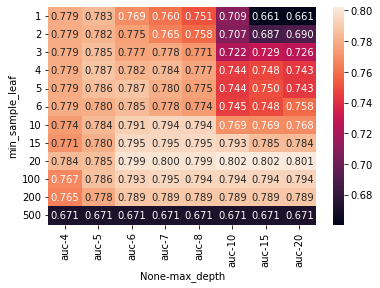

In [113]:
sns.heatmap(df_scores_pivot, annot=True,fmt = '.3f')

In [114]:
dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=20)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)

# Ensembles and Random Forest

In [115]:
from sklearn.ensemble import RandomForestClassifier

In [122]:
rf = RandomForestClassifier(n_estimators=10,random_state=1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [123]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [124]:
roc_auc_score(y_val,y_pred)

0.7874819219026192

In [125]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n,random_state=1)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val,y_pred)
    
    scores.append((n,auc))

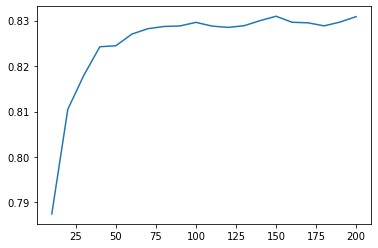

In [128]:
plt.plot(df_scores.n_estimators,df_scores.auc)

In [129]:
scores = []

for d in [5,10,15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train,y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val,y_pred)

        scores.append((d,n,auc))

In [132]:
columns = ['max_depth','n_estimators','auc']
df_scores = pd.DataFrame(scores,columns = columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.821413
1,5,20,0.827767
2,5,30,0.828592
3,5,40,0.826429
4,5,50,0.827671


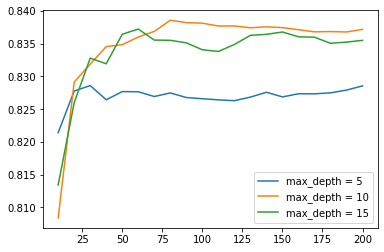

In [133]:
for d in [5,10,15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators,df_subset.auc,label = 'max_depth = %s' % d)
    plt.legend()

In [134]:
max_depth = 10

In [136]:
scores = []

for s in [1,3,5,10,50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth = max_depth,
                                    min_samples_leaf= s,
                                    random_state = 1)
        rf.fit(X_train,y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val,y_pred)

        scores.append((s,n,auc))

In [137]:
columns = ['min_sample_leaf','n_estimators','auc']
df_scores = pd.DataFrame(scores,columns = columns)
df_scores.head()

,min_sample_leaf,n_estimators,auc
0,1,10,0.808406
1,1,20,0.829126
2,1,30,0.831864
3,1,40,0.834534
4,1,50,0.834831


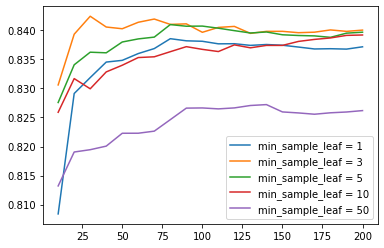

In [138]:
for s in [1,3,5,10,50]:
    df_subset = df_scores[df_scores.min_sample_leaf == s]
    
    plt.plot(df_subset.n_estimators,df_subset.auc,label = 'min_sample_leaf = %s' % s)
    plt.legend()

In [140]:
min_samples_leaf = 3

In [142]:
rf = RandomForestClassifier(n_estimators=100,
                                    max_depth = max_depth,
                                    min_samples_leaf= min_samples_leaf,
                                    random_state = 1,
                                    n_jobs= -1)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_jobs=-1,
                       random_state=1)

# XGboost

In [144]:
!pip install xgboost

In [145]:
import xgboost as xgb

In [147]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names= features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names= features)

C:\Santhosh\SoftWares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [154]:
xgb_params = {
    'eta' : 0.3,
    'max_depth' : 6,
    'min_child_weight' : 1,
    'objective' : 'binary:logistic',
    'nthread' : 8,
    'seed' : 1,
    'verbosity' : 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round= 10)

In [155]:
y_pred = model.predict(dval)
roc_auc_score(y_val , y_pred)

0.8224329101719429

In [156]:
watchlist = [(dtrain, 'train'),(dval, 'val')]

In [168]:
%%capture output

xgb_params = {
    'eta' : 0.3,
    'max_depth' : 6,
    'min_child_weight' : 1,
    'objective' : 'binary:logistic',
    'eval_metric':'auc',
    'nthread' : 8,
    'seed' : 1,
    'verbosity' : 1,
}

model = xgb.train(xgb_params, dtrain,evals=watchlist,verbose_eval=5, num_boost_round= 200)

In [177]:
s = output.stdout
print(s)

[0]	train-auc:0.84697	val-auc:0.78566
[5]	train-auc:0.92374	val-auc:0.81273
[10]	train-auc:0.95016	val-auc:0.82366
[15]	train-auc:0.96575	val-auc:0.82803
[20]	train-auc:0.97463	val-auc:0.82474
[25]	train-auc:0.98257	val-auc:0.82326
[30]	train-auc:0.98565	val-auc:0.82253
[35]	train-auc:0.98934	val-auc:0.82214
[40]	train-auc:0.99299	val-auc:0.82257
[45]	train-auc:0.99525	val-auc:0.82192
[50]	train-auc:0.99690	val-auc:0.82158
[55]	train-auc:0.99823	val-auc:0.82162
[60]	train-auc:0.99881	val-auc:0.82012
[65]	train-auc:0.99905	val-auc:0.81994
[70]	train-auc:0.99941	val-auc:0.81969
[75]	train-auc:0.99958	val-auc:0.81840
[80]	train-auc:0.99977	val-auc:0.81609
[85]	train-auc:0.99989	val-auc:0.81678
[90]	train-auc:0.99995	val-auc:0.81545
[95]	train-auc:0.99999	val-auc:0.81522
[100]	train-auc:1.00000	val-auc:0.81719
[105]	train-auc:1.00000	val-auc:0.81665
[110]	train-auc:1.00000	val-auc:0.81746
[115]	train-auc:1.00000	val-auc:0.81797
[120]	train-auc:1.00000	val-auc:0.81769
[125]	train-auc:1.0000

In [182]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
        
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns = columns)
    return df_results

In [185]:
df_score = parse_xgb_output(output)

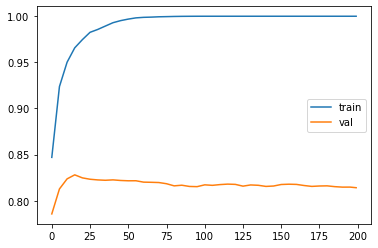

In [189]:
plt.plot(df_score.num_iter,df_score.train_auc,label = 'train')
plt.plot(df_score.num_iter,df_score.val_auc,label = 'val')
plt.legend()

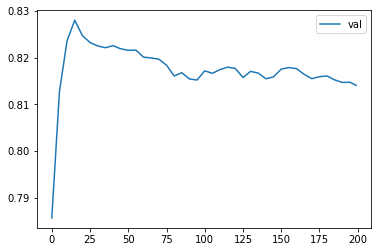

In [187]:
plt.plot(df_score.num_iter,df_score.val_auc,label = 'val')
plt.legend()

# XGBoost Parameter Tuning :

In [210]:
scores = {}

In [226]:
%%capture output

xgb_params = {
    'eta' : 0.01,
    'max_depth' : 6,
    'min_child_weight' : 1,
    
    'objective' : 'binary:logistic',
    'eval_metric':'auc',
    
    'nthread' : 8,
    'seed' : 1,
    'verbosity' : 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,verbose_eval=5,
                  num_boost_round= 200)

In [227]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

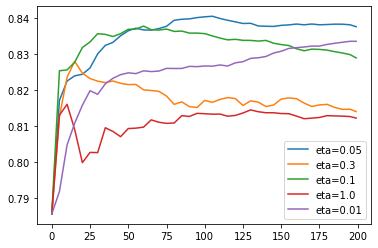

In [229]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label = key)
plt.legend()

In [230]:
scores = {}

In [237]:
%%capture output

xgb_params = {
    'eta' : 0.01,
    'max_depth' : 10,
    'min_child_weight' : 1,
    
    'objective' : 'binary:logistic',
    'eval_metric':'auc',
    
    'nthread' : 8,
    'seed' : 1,
    'verbosity' : 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,verbose_eval=5,
                  num_boost_round= 200)

In [238]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

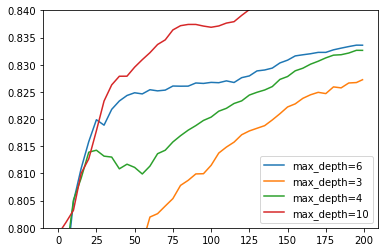

In [240]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label = max_depth)

plt.ylim(0.8, 0.84)    
plt.legend()

In [244]:
del scores['max_depth=10']
del scores['max_depth=4']
del scores['max_depth=6']
del scores['max_depth=3']

In [247]:
%%capture output

xgb_params = {
    'eta' : 0.01,
    'max_depth' : 3,
    'min_child_weight' : 30,
    
    'objective' : 'binary:logistic',
    'eval_metric':'auc',
    
    'nthread' : 8,
    'seed' : 1,
    'verbosity' : 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,verbose_eval=5,
                  num_boost_round= 200)

In [248]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

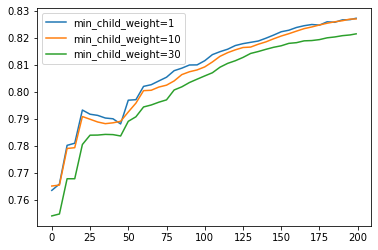

In [252]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label = min_child_weight)
 
plt.legend()

In [253]:
xgb_params = {
    'eta' : 0.01,
    'max_depth' : 3,
    'min_child_weight' : 30,
    
    'objective' : 'binary:logistic',
    'eval_metric':'auc',
    
    'nthread' : 8,
    'seed' : 1,
    'verbosity' : 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,verbose_eval=5,
                  num_boost_round= 175)

[0]	train-auc:0.75874	val-auc:0.75396
[5]	train-auc:0.75946	val-auc:0.75468
[10]	train-auc:0.77527	val-auc:0.76774
[15]	train-auc:0.77527	val-auc:0.76774
[20]	train-auc:0.79266	val-auc:0.78043
[25]	train-auc:0.79650	val-auc:0.78389
[30]	train-auc:0.79714	val-auc:0.78393
[35]	train-auc:0.79811	val-auc:0.78418
[40]	train-auc:0.79827	val-auc:0.78410
[45]	train-auc:0.80189	val-auc:0.78359
[50]	train-auc:0.81011	val-auc:0.78903
[55]	train-auc:0.81110	val-auc:0.79071
[60]	train-auc:0.81453	val-auc:0.79435
[65]	train-auc:0.81642	val-auc:0.79508
[70]	train-auc:0.81804	val-auc:0.79612
[75]	train-auc:0.81919	val-auc:0.79698
[80]	train-auc:0.82219	val-auc:0.80065
[85]	train-auc:0.82386	val-auc:0.80181
[90]	train-auc:0.82530	val-auc:0.80341
[95]	train-auc:0.82648	val-auc:0.80465
[100]	train-auc:0.82786	val-auc:0.80586
[105]	train-auc:0.82913	val-auc:0.80703
[110]	train-auc:0.83057	val-auc:0.80910
[115]	train-auc:0.83255	val-auc:0.81051
[120]	train-auc:0.83347	val-auc:0.81149
[125]	train-auc:0.8348

# Selecting the Best Model :

In [263]:
dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=20)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)

In [270]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

#performance of decision tree

0.801786795881284

In [268]:
rf = RandomForestClassifier(n_estimators=200,
                                    max_depth = 10,
                                    min_samples_leaf= 3,
                                    random_state = 1,
                                    n_jobs= -1)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1, random_state=1)

In [271]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

#performance of Random Forest

0.8400351055019221

In [265]:
xgb_params = {
    'eta' : 0.01,
    'max_depth' : 3,
    'min_child_weight' : 1,
    
    'objective' : 'binary:logistic',
    'eval_metric':'auc',
    
    'nthread' : 8,
    'seed' : 1,
    'verbosity' : 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,verbose_eval=5,
                  num_boost_round= 175)

[0]	train-auc:0.75874	val-auc:0.75396
[5]	train-auc:0.75946	val-auc:0.75468
[10]	train-auc:0.77527	val-auc:0.76774
[15]	train-auc:0.77527	val-auc:0.76774
[20]	train-auc:0.79266	val-auc:0.78043
[25]	train-auc:0.79650	val-auc:0.78389
[30]	train-auc:0.79714	val-auc:0.78393
[35]	train-auc:0.79811	val-auc:0.78418
[40]	train-auc:0.79827	val-auc:0.78410
[45]	train-auc:0.80189	val-auc:0.78359
[50]	train-auc:0.81011	val-auc:0.78903
[55]	train-auc:0.81110	val-auc:0.79071
[60]	train-auc:0.81453	val-auc:0.79435
[65]	train-auc:0.81642	val-auc:0.79508
[70]	train-auc:0.81804	val-auc:0.79612
[75]	train-auc:0.81919	val-auc:0.79698
[80]	train-auc:0.82219	val-auc:0.80065
[85]	train-auc:0.82386	val-auc:0.80181
[90]	train-auc:0.82530	val-auc:0.80341
[95]	train-auc:0.82648	val-auc:0.80465
[100]	train-auc:0.82786	val-auc:0.80586
[105]	train-auc:0.82913	val-auc:0.80703
[110]	train-auc:0.83057	val-auc:0.80910
[115]	train-auc:0.83255	val-auc:0.81051
[120]	train-auc:0.83347	val-auc:0.81149
[125]	train-auc:0.8348

In [274]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

#performance of Random Forest

0.8193549982076418

In [275]:
df_full_train = df_full_train.reset_index(drop = True)
y_full_train = (df_full_train.status == 'default').astype(int).values

In [277]:
del df_full_train['status']

In [279]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.fit_transform(dicts_test)

In [293]:
dfulltrain = xgb.DMatrix(X_full_train,
                         label=y_full_train,
                         )

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

In [294]:
xgb_params = {
    'eta' : 0.01,
    'max_depth' : 3,
    'min_child_weight' : 1,
    
    'objective' : 'binary:logistic',
    'eval_metric':'auc',
    
    'nthread' : 8,
    'seed' : 1,
    'verbosity' : 1,
}

model = xgb.train(xgb_params, dfulltrain,num_boost_round=175)

In [295]:
y_pred = model.predict(dtest)

In [296]:
roc_auc_score(y_test,y_pred)

0.7677297122843926